In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
import imblearn
import seaborn 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [18]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# I. Introduction et motivations

### Objectif Global :
Le triple objectif de ce projet est : 
- La prise en main/découverte de Python.
- L'étude de différents outil de Machine Learning.
- L'étude des performances de prédiction de nos outils sur des données.

Pour ce faire nous avons choisit d'appliquer notre travail sur un problème de sociale majeur : La discrimination sur le marché de l'immobilier. Le recherche d'une base de données sur sujet a été compliqué. Ainsi, nous nous sommes concentré sur la question de l'ocroit ou non d'un pret immobilier, grâce à une base de données receuilli dans les années 90 par la réserve féderal de Boston. L'intérêt pour nous et de savoir si l'éthnie d'un demandeurs de prêt immobilier peut impacter l'octroi de son crédit.
Beaucoup d'étude ont été réalisé sur ce sujet dans les années 70 à 90 aux États-Unis. Il peut être intéressant de comparer nos résultats à ces données.


#### Découverte des variables de la base de données :

Pour commencer découvrons la composition de notre base de données. La variable que nous cherchons à expliquer est approve, une variable binaire qui indique si l'individu a obtenu ou non son prêt. Au total nous avons 19 variables explicatives, dont 11 quatégorielles et 8 quantitatives. 

Nous avons des variables qui permettent de décrire le prêt demandé, comme le durée de remboursement du prêt (variable quantitative **term**), le montant du prêt (variable quantitative **loanamt**). 

Nous avons des variables qui permettent de connaitre qui est le demandeur et qu'elle est sa situation : son sexe (variable factorielle **sex**), s'il a été à l'université (variable binaire **university**), s'il est marié (variable bianire **married**), le nombre de personne qu'il a à sa charge (variable quantitative **dep**), son revenu mensuel et celui de son conjoint (variable quantitative **atotinc**, **cototinc**), ainsi que le nombre d'années d'expériance professionnel (**exper**).

Pour finir, nous avons également a disposition des variables permettant de définir le profil et antécedant financier du demandeur de prêt. En effet, nous avons le ratio des frais de logement, pourcentage total sur revenu (**hrat**), les autres dépenses, en pourcentage du revenu total (**obrat**). Nous avons un score de solvabilité allant de 0 à 9 (**score**), et enfin une variable indiquant s'il n'y a pas d'historique de non-remboursement de crédit à la consommation, une autre indiquant s'il y a eu 1 ou 2 retards de paiement, et une indiquant s'il y a eu plus de deux retards de paiement (variables binaires **delinq**, **morperf**, **mortlat1**, **mortlat2**).

In [19]:
#data = pd.read_csv('Loan_data.csv')
data = pd.read_csv('Loan_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 20 columns):
approve       1989 non-null int64
loanamt       1989 non-null int64
term          1989 non-null float64
caution       1989 non-null int64
atotinc       1989 non-null int64
cototinc      1989 non-null float64
hrat          1989 non-null float64
obrat         1989 non-null float64
sex           1974 non-null object
university    1989 non-null int64
race          1989 non-null object
married       1986 non-null float64
dep           1986 non-null float64
exper         1989 non-null int64
self          1989 non-null int64
score         1980 non-null float64
delinq        1989 non-null int64
mortperf      1989 non-null int64
mortlat1      1989 non-null int64
mortlat2      1989 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 310.9+ KB


Toujours dans l'idée de découvrir la population que nous observons, nous affichons ci-dessous des informations statistique de nos variables quantitatives et binaires. 

In [20]:
data.describe()

,approve,loanamt,term,caution,atotinc,cototinc,hrat,obrat,university,married,dep,exper,self,score,delinq,mortperf,mortlat1,mortlat2
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1986.000000,1986.000000,1989.000000,1989.000000,1980.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,0.877325,143.245349,2351.459779,0.028658,5195.549522,1547.177235,24.790915,32.389035,0.771745,0.658610,0.770896,0.209653,0.129211,1.503030,0.837607,0.638512,0.019105,0.010558
std,0.328146,80.520410,44795.737413,0.166884,5269.055628,2361.813345,7.119459,8.263018,0.419814,0.474295,1.104321,1.003910,0.335517,0.986258,0.368904,0.480552,0.136929,0.102234
min,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,100.000000,360.000000,0.000000,2876.000000,0.000000,21.000000,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,126.000000,360.000000,0.000000,3813.000000,1145.000000,25.770000,33.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,165.000000,360.000000,0.000000,5596.000000,2417.000000,29.000000,37.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,980.000000,999999.375000,1.000000,81000.000000,41667.000000,72.000000,95.000000,1.000000,1.000000,8.000000,9.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
data.isnull().sum()
data1=data.dropna() #Suppression de 26 lignes
data1.shape

(1963, 20)

# Etape 1: Visualisation des données pour la detection d'outlier

In [22]:
#Création d'une nouvelle table contenant seulement les variables quantitatives
col = [ 1, 2, 4, 5, 6, 7, 12, 13]
data_quanti = data1.iloc[: , col]
#data_quanti.shape
#data_quanti.info()

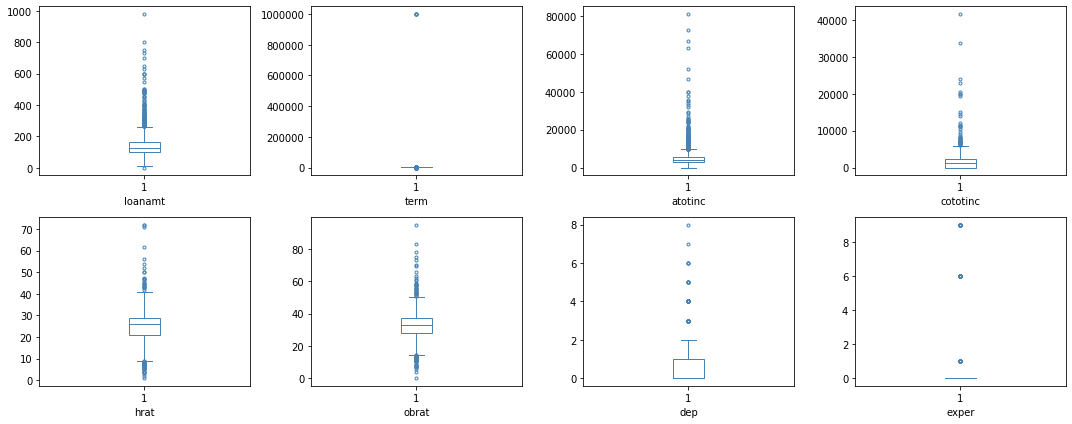

In [23]:
#Boxplot pour les variables quatitatives
c = 'steelblue'
blue_dict =  {'patch_artist': True,
             'boxprops': dict(color=c, facecolor='w'),
             'capprops': dict(color=c),
             'flierprops': dict(color=c, markeredgecolor=c,marker="."),
             'medianprops': dict(color=c),
             'whiskerprops': dict(color=c)}

plt.close()
plt.figure(figsize=(15,6))
for i in np.arange(start=0,stop=data_quanti.shape[1]):
    plt.subplot(2, 4, i+1)
    plt.boxplot(data_quanti.iloc[:,i],**blue_dict)
    plt.xlabel(data_quanti.columns[i])
plt.tight_layout()
plt.show()

Les boites à moustache nous permettent de détecter des valeurs extremes ou abérrantes. On remarque notament pour la variable **term** des valeurs qui semblent abérantes. En effet, pour 3 individus le nombre de mois de demandé pour rembrouser le crédit immobilier et de 1 000 000. On peut supposer que des 0 sont en trop, ou qu'il s'agit de cas extreme. Nous préferons donc les exclures de la base de données.

In [24]:
#Suppression d'outliers
data_quanti=data_quanti[(data_quanti["term"]<500)] 
data2=data1[(data1["term"]<500)] 
data2.shape

(1959, 20)

# Etape 2: Analyse Univariée

## 2.1. Analyse univariée des variables quantitatives

Dans le jeu de données « Loan_data.csv », il y a 8 variables quantitatives (loanmt, term, atotinc, cototinc, hart, obrat, dep et exper). Pour chacune de ces variables, nous présentons les paramètres de tendances centrales (Moyenne, Maximum, Minimum, quantiles (25%, 50% et 75%)) et l’écart-type comme indicateur de dispersion.

### 2.1.1. Parametres des tendances centrales et indicateur de dispersion.

In [25]:
# Tableau des indicateurs
col = [ 1, 2, 4, 5, 6, 7, 12, 13]
data2.iloc[: , col].describe()

,loanamt,term,atotinc,cototinc,hrat,obrat,dep,exper
count,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000
mean,143.493619,340.835120,5160.489535,1552.738397,24.850373,32.452318,0.771822,0.207759
std,80.920571,64.770711,5206.785465,2373.606577,7.085904,8.226071,1.105979,0.991394
min,2.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,100.000000,360.000000,2875.000000,0.000000,21.000000,28.000000,0.000000,0.000000
50%,127.000000,360.000000,3794.000000,1152.000000,25.900000,33.000000,0.000000,0.000000
75%,165.000000,360.000000,5583.000000,2417.000000,29.000000,37.000000,1.000000,0.000000
max,980.000000,480.000000,81000.000000,41667.000000,72.000000,95.000000,8.000000,9.000000


D'après les résultats du tableau des indicateurs ci-dessus, nous remarquons que le montant du prêt immobilier est compris entre 2,000.00 et 980,000.00 dollars US. Le montant du prêt immobilier est en moyenne de 143,493.619 dollars US. La durée moyenne du prêt est de 341 mois environ et la durée minimale respectivement maximale du prêt immobilier est respectivement 6 et 480 mois. Le revenu moyen mensuel total des emprunteurs est de 5160.490 dollars US. Le ratio des frais de logement par rapport au revenu (pourcentage total sur revenu) est de 24.85 c'est-à-dire que le revenu total des emprunteurs est 24 fois plus élevé que leur frais de logement en moyenne et ce ratio est compris entre 1 et 72. En outre, Le ratio des autres dépenses par rapport au revenu est de 32.45 en moyenne alors nous pouvons dire que les frais de logement représentent une grande part du budget des dépenses des emprunteurs. En moyenne, les personnes demandant le prêt ont seulement une personne à leur charge et ont en moyenne moins d'une année expérience professionnel.

### 2.1.2. Représentation graphique des variables quantitatives

**Graphiques : Distribution des variables**

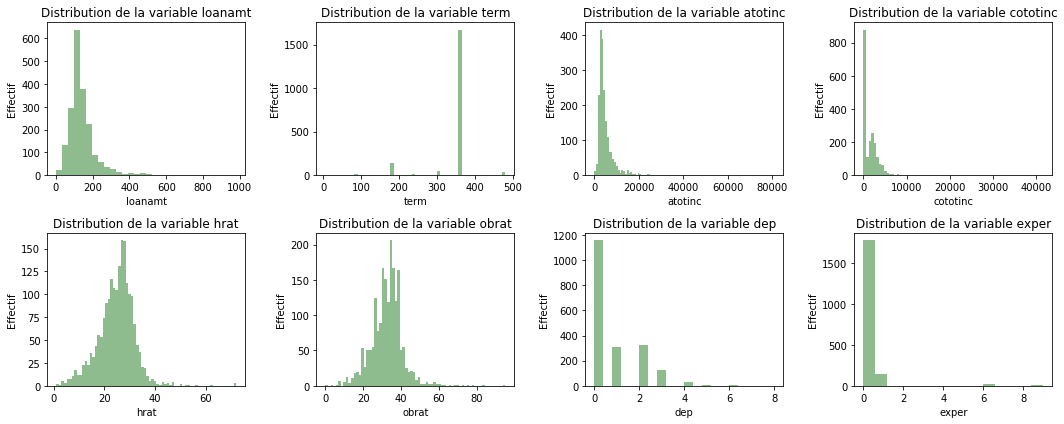

In [26]:
# Graphique: Distribution
b=[30,50,100,70,70,70,20,15]
plt.figure(figsize=(15,6))
for i in np.arange(start=0,stop=data_quanti.shape[1]):
    plt.subplot(2, 4, i+1)
    plt.hist(data_quanti.iloc[: , i], bins=b[i], color='darkseagreen')
    plt.xlabel(data_quanti.columns[i])
    plt.ylabel('Effectif')
    plt.title('Distribution de la variable ' + data_quanti.columns[i])
plt.tight_layout()
plt.show()


Le graphique ci-dessus represente la distribution de la variable loanamt, en ordonnée, il y a la fréquence absolue des emprunteurs et en abscisse, il y a le montant le montant du prêt immobilier (en millier de dollar). Donc, le graphique montre que montant du pret le plus demandé par les empruteurs varie entre 50,000.00 et 200,000.00 dollars US.

## 2.2.  Analyse Univarée des variables qualitatives

Dans la base de données "Loan_data.csv", nous avons 12 variables qualitatives que nous allons analyser ces variables en présentant un graphique pour visualiser leur distribution et en donant un tri a plat de chaque variable.

### 2.2.1. Tri à plat et graphique des variables qualitatives.

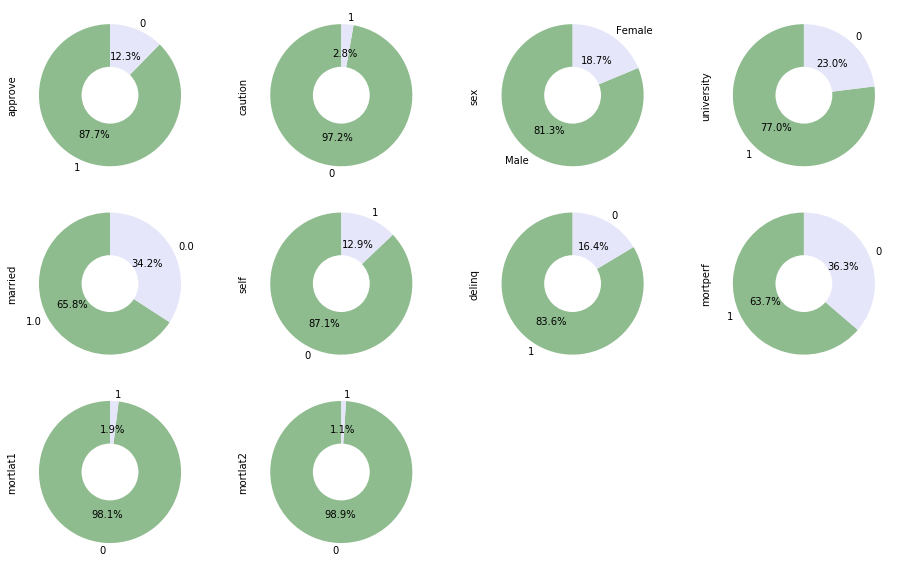

In [27]:
#Pie des varibales qualitatives binaires
col1=[0,3,8,9,11,14,16,17,18,19]
j=1
plt.figure(figsize=(13,8))
for i in col1:
    plt.subplot(3, 4, j)
    j=j+1
    data2.iloc[:,i].value_counts().plot.pie(subplots=True ,
                                                 autopct='%1.1f%%',
                                                 startangle=90, 
                                                 colors = ['darkseagreen','lavender'])
    centre_circle = plt.Circle((0,0),0.4,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle) 
plt.tight_layout() 
plt.show()

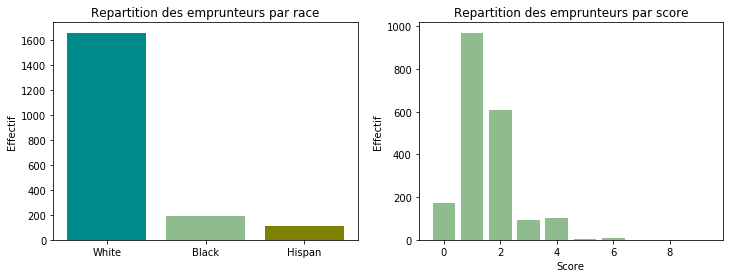

In [28]:
# Bar plot de la variable race 
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.bar(data2['race'].value_counts().index, data2['race'].value_counts().values , color=['darkcyan','darkseagreen', 'olive'], width=0.8)
plt.ylabel('Effectif')
plt.title('Repartition des emprunteurs par race')

# Bar plot de la variable score
plt.subplot(1, 2, 2)
plt.bar(data2['score'].value_counts().index, data2['score'].value_counts().values, color=['darkseagreen'])
plt.ylabel('Effectif')
plt.xlabel('Score')
plt.title('Repartition des emprunteurs par score')
plt.show()

# Etape 3 : Analyse Bivariée

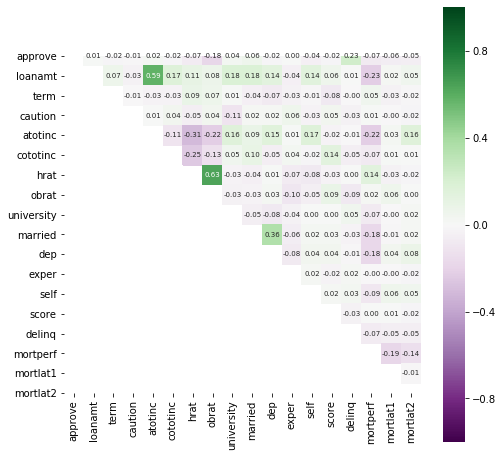

In [29]:
#Matrice de corrélation
plt.figure(figsize=(8,8))
masque  =  np.tril(data1.corr())
sns.heatmap(data2.corr(),annot=True,annot_kws={"size": 7}, vmin=-1, vmax=1,fmt='.2f',cmap= 'PRGn' ,square=True,mask = masque)
plt.show() 

In [16]:
#Attention long a executer
sns.pairplot(data2);

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1c174eb5f0> (for post_execute):


KeyboardInterrupt: 

# Etape 4 : Analyse Multivariée

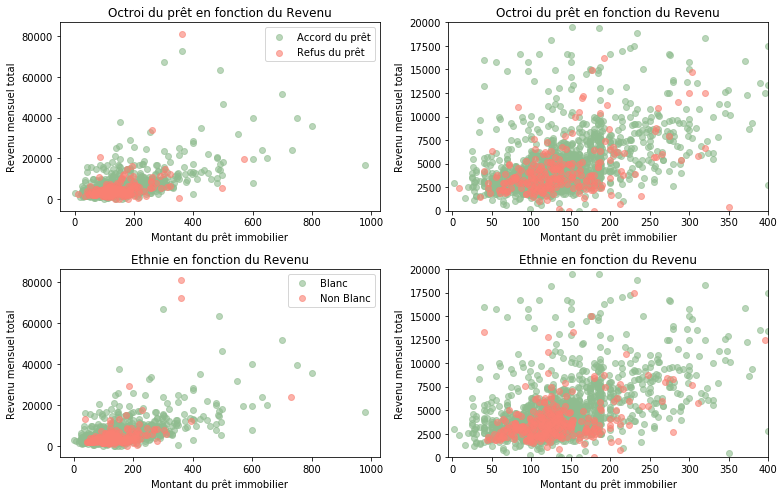

In [30]:
plt.figure(figsize=(11,7))
plt.subplot(2, 2, 1)
plt.scatter(data2[data2["approve"]==1]["loanamt"], data2[data2["approve"]==1]["atotinc"],alpha=0.6,c='darkseagreen');
plt.scatter(data2[data2["approve"]==0]["loanamt"], data2[data2["approve"]==0]["atotinc"],alpha=0.6,c='salmon');
plt.xlabel('Montant du prêt immobilier')
plt.ylabel('Revenu mensuel total')
plt.title('Octroi du prêt en fonction du Revenu');
plt.legend( ["Accord du prêt", "Refus du prêt"]);
plt.subplot(2, 2, 2)
plt.scatter(data2[data2["approve"]==1]["loanamt"], data2[data2["approve"]==1]["atotinc"],alpha=0.6,c='darkseagreen');
plt.scatter(data2[data2["approve"]==0]["loanamt"], data2[data2["approve"]==0]["atotinc"],alpha=0.6,c='salmon');
plt.axis([-5, 400, -5, 20000])
plt.xlabel('Montant du prêt immobilier')
plt.ylabel('Revenu mensuel total')
plt.title('Octroi du prêt en fonction du Revenu');

plt.subplot(2, 2, 3)
temp=data2.sort_values("race",ascending=False)
plt.scatter(data2[data2["race"]=="White"]["loanamt"], data2[data2["race"]=="White"]["atotinc"],alpha=0.6,c='darkseagreen');
plt.scatter(data2[data2["race"]!="White"]["loanamt"], data2[data2["race"]!="White"]["atotinc"],alpha=0.6,c='salmon');
plt.xlabel('Montant du prêt immobilier')
plt.ylabel('Revenu mensuel total')
plt.title('Ethnie en fonction du Revenu');
plt.legend( ["Blanc", "Non Blanc"]);
plt.subplot(2, 2, 4)
plt.scatter(data2[data2["race"]=="White"]["loanamt"], data2[data2["race"]=="White"]["atotinc"],alpha=0.6,c='darkseagreen');
plt.scatter(data2[data2["race"]!="White"]["loanamt"], data2[data2["race"]!="White"]["atotinc"],alpha=0.6,c='salmon');
plt.axis([-5, 400, -5, 20000])
plt.xlabel('Montant du prêt immobilier')
plt.ylabel('Revenu mensuel total')
plt.title('Ethnie en fonction du Revenu');
plt.tight_layout() 

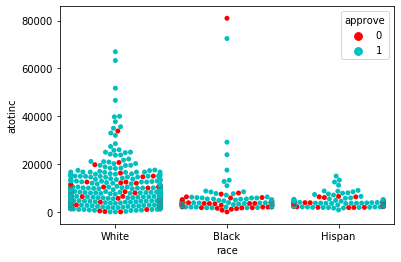

In [31]:
#je sais pas si on garde
sns.swarmplot(x="race", y="atotinc",hue='approve',
              palette=["r", "c", "y"], data=data2)
plt.show()

# Etape 5 : Echantillonnage

#### Création des variables dummies

In [32]:
data2 = pd.get_dummies(data2)

In [33]:
data_X,test_X, data_y, test_y = train_test_split(data2.drop(['approve'], axis=1),
                                                 data2["approve"], 
                                                 test_size=0.2, 
                                                 random_state=5, 
                                                 stratify=data2["approve"])

#### Echantillonage

In [34]:
data_X,test_X, data_y, test_y = train_test_split(data2.drop(['approve'], axis=1),
                                                 data2["approve"], 
                                                 test_size=0.2, 
                                                 random_state=5, 
                                                 stratify=data2["approve"])

#### Rééquilibrage de la BDD d'entrainement

In [35]:
os = SMOTE(random_state=1)
os_data_X,os_data_y=os.fit_sample(data_X, data_y)
print("Longueur de la nouvelle BDD",len(os_data_X))
print(os_data_y.value_counts())


Longueur de la nouvelle BDD 2748
1    1374
0    1374
Name: approve, dtype: int64


#### Normalisation des données

In [36]:
data_X_scale=preprocessing.scale(os_data_X)

scaler = preprocessing.StandardScaler().fit(data_X_scale)

test_scale_X=scaler.transform(test_X)

In [37]:
data_X_scale = pd.DataFrame(data=data_X_scale, columns=os_data_X.columns)
test_scale_X = pd.DataFrame(data=test_scale_X, columns=os_data_X.columns)

# Etape 6 : Modélisation

- La Regression Logistique
- Les Arbres de décision
- Les Fôrets Aléatoires
- ( Boosting ? réseau de neurones ? )

## 1. La Régression Logistique

In [38]:
logit = sm.Logit(os_data_y, os_data_X.astype(float))
result=logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.396639
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.428    
Dependent Variable: approve          AIC:              2223.9297
Date:               2020-11-22 19:34 BIC:              2354.1395
No. Observations:   2748             Log-Likelihood:   -1090.0  
Df Model:           21               LL-Null:          -1904.8  
Df Residuals:       2726             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
loanamt          0.0013   0.0011   1.1866 0.2354 -0.0008  0.0034
term            -0.0075   0.0008  -8.8177 0.0000 -0.0091 -0.0058
caution      

###  Selection des variables (Amélioration du critère BIC)

In [39]:
select_data=os_data_X.drop(['dep','exper','self','mortperf','mortlat2','mortlat1','hrat','loanamt','cototinc'], axis='columns')
select_test=test_X.drop(['dep','exper','self','mortperf','mortlat2','mortlat1','hrat','loanamt','cototinc'], axis='columns')

logit2 = sm.Logit(os_data_y,select_data.astype(float))
result2=logit2.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.398863
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.425    
Dependent Variable: approve          AIC:              2218.1536
Date:               2020-11-22 19:34 BIC:              2295.0957
No. Observations:   2748             Log-Likelihood:   -1096.1  
Df Model:           12               LL-Null:          -1904.8  
Df Residuals:       2735             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
term            -0.0074   0.0008  -9.0722 0.0000 -0.0090 -0.0058
caution          1.9539   0.5351   3.6516 0.0003  0.9051  3.0026
atotinc      

###  Prédiction - Étude des performances de prédiction

In [40]:
logreg = LogisticRegression()
modellogit=logreg.fit(select_data,os_data_y)
y_pred=logreg.predict(select_test)

conf = confusion_matrix(test_y, logreg.predict(select_test))
cf = pd.DataFrame(conf, columns=[logreg.classes_])
cf.index = [ logreg.classes_]
cf

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,0,1
0,29,19
1,67,277


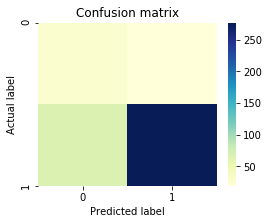

In [42]:
plt.figure(figsize=(4,3))
#fig, ax = plt.subplots() #Affichage a changer !
sns.heatmap(conf, annot=False,cmap="YlGnBu",annot_kws={"size": 15,"ha": 'center',"va": 'center'},fmt='g');
#ax.xaxis.set_label_position("bottom")
#plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [44]:
scor = logreg.decision_function(select_test)
df = {'scor':scor,'approve':test_y,'pred':logreg.predict(select_test)}
df=pd.DataFrame(data=df)

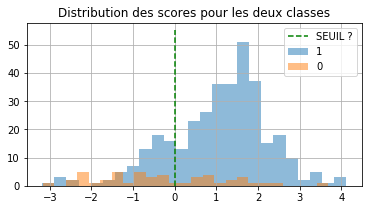

In [45]:
ax = df[df['approve'] == 1]['scor'].hist(bins=25, figsize=(6,3), label='1', alpha=0.5)
df[df['approve'] == 0]['scor'].hist(bins=25, ax=ax, label='0', alpha=0.5)
ax.set_title("Distribution des scores pour les deux classes")
ax.plot([0, 0], [0, 55], 'g--', label="SEUIL ?")
ax.legend();

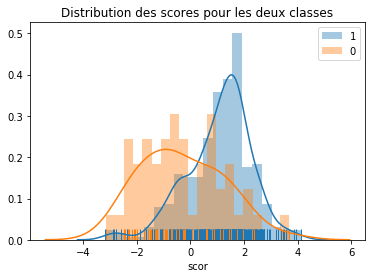

In [46]:
ax = seaborn.distplot(df[df['approve'] == 1]['scor'], rug=True,bins=20, hist=True, label="1")
seaborn.distplot(df[df['approve'] == 0]['scor'], rug=True, hist=True,bins=20, ax=ax, label="0")
ax.set_title("Distribution des scores pour les deux classes")
ax.legend()

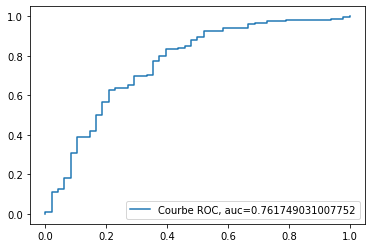

In [47]:
#  Courbe ROC
pred_proba = logreg.predict_proba(select_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_y,  pred_proba)
r_auc = metrics.roc_auc_score(test_y, pred_proba)
plt.plot(fpr,tpr,label="Courbe ROC, auc="+str(r_auc))
plt.legend(loc=4)
plt.show()

Logistic: f1=0.866 auc=0.943


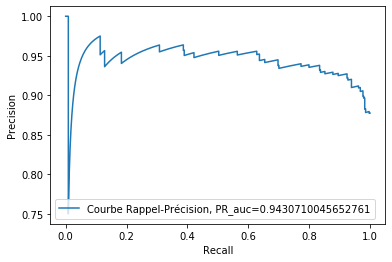

In [48]:
#  Courbe Rappel Précision
lr_precision, lr_recall, _ = precision_recall_curve(test_y, pred_proba)
lr_f1, lr_auc = f1_score(test_y, y_pred), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
plt.plot(lr_recall, lr_precision, label='Courbe Rappel-Précision, PR_auc='+str(lr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## 2. Arbre de décision

In [93]:
data2.info()
#Il faut récupérer les variables qualitatives

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 1 to 1988
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   approve      1959 non-null   int64  
 1   loanamt      1959 non-null   int64  
 2   term         1959 non-null   float64
 3   caution      1959 non-null   int64  
 4   atotinc      1959 non-null   int64  
 5   cototinc     1959 non-null   float64
 6   hrat         1959 non-null   float64
 7   obrat        1959 non-null   float64
 8   university   1959 non-null   int64  
 9   married      1959 non-null   float64
 10  dep          1959 non-null   float64
 11  exper        1959 non-null   int64  
 12  self         1959 non-null   int64  
 13  score        1959 non-null   float64
 14  delinq       1959 non-null   int64  
 15  mortperf     1959 non-null   int64  
 16  mortlat1     1959 non-null   int64  
 17  mortlat2     1959 non-null   int64  
 18  sex_Female   1959 non-null   uint8  
 19  sex_Ma

In [94]:
col_quali=[0,3,18,19,8,20,21,22,9,12,13,14,15,16,17]
df = data2.iloc[:,col_quali]

In [95]:
#vérification de la version de scikit-learn
import sklearn
print(sklearn.__version__)

0.23.1


In [96]:
#Dimension du dataframe :
df.shape

(1959, 15)

In [97]:
#Affichages des premières lignes 
df.head()

,approve,caution,sex_Female,sex_Male,university,race_Black,race_Hispan,race_White,married,self,score,delinq,mortperf,mortlat1,mortlat2
1,0,0,0,1,1,0,0,1,1.0,0,3.0,1,1,0,0
2,1,0,0,1,1,0,0,1,0.0,0,6.0,1,1,0,0
3,1,0,0,1,1,0,0,1,1.0,1,1.0,0,1,0,0
4,1,0,0,1,0,0,0,1,1.0,0,1.0,1,1,0,0
5,1,0,0,1,0,0,0,1,0.0,0,2.0,0,1,0,0


In [98]:
#Affichage des informations sur le type de variables :
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 1 to 1988
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   approve      1959 non-null   int64  
 1   caution      1959 non-null   int64  
 2   sex_Female   1959 non-null   uint8  
 3   sex_Male     1959 non-null   uint8  
 4   university   1959 non-null   int64  
 5   race_Black   1959 non-null   uint8  
 6   race_Hispan  1959 non-null   uint8  
 7   race_White   1959 non-null   uint8  
 8   married      1959 non-null   float64
 9   self         1959 non-null   int64  
 10  score        1959 non-null   float64
 11  delinq       1959 non-null   int64  
 12  mortperf     1959 non-null   int64  
 13  mortlat1     1959 non-null   int64  
 14  mortlat2     1959 non-null   int64  
dtypes: float64(2), int64(8), uint8(5)
memory usage: 257.9 KB


In [99]:
#Vérifions la distribution absolue des approve
df.approve.value_counts()

1    1718
0     241
Name: approve, dtype: int64

In [100]:
#Distribution relative 
df.approve.value_counts(normalize=True)

1    0.876978
0    0.123022
Name: approve, dtype: float64

In [101]:
os_data_X.shape 

(2748, 22)

In [102]:
test_X.shape # c'est une séries

(392, 22)

In [103]:
os_data_y.value_counts(normalize=True)

1    0.5
0    0.5
Name: approve, dtype: float64

In [104]:
test_y.value_counts(normalize=True)

1    0.877551
0    0.122449
Name: approve, dtype: float64

In [105]:
#instanciation de l'arbre
from sklearn.tree import DecisionTreeClassifier
arbreFirst = DecisionTreeClassifier(min_samples_split=300,min_samples_leaf=100)
#Je ne sais pas comment définir ces 2 paramètres 

In [106]:
arbreFirst.fit(X = os_data_X, y = os_data_y) 

DecisionTreeClassifier(min_samples_leaf=100, min_samples_split=300)

[Text(118.80000000000001, 201.90857142857143, 'race_White <= 0.5\ngini = 0.5\nsamples = 2748\nvalue = [1374, 1374]'),
 Text(64.80000000000001, 170.84571428571428, 'race_Black <= 0.5\ngini = 0.287\nsamples = 977\nvalue = [807, 170]'),
 Text(43.2, 139.78285714285715, 'race_Hispan <= 0.5\ngini = 0.154\nsamples = 724\nvalue = [663, 61]'),
 Text(21.6, 108.72, 'gini = 0.0\nsamples = 617\nvalue = [617, 0]'),
 Text(64.80000000000001, 108.72, 'gini = 0.49\nsamples = 107\nvalue = [46, 61]'),
 Text(86.4, 139.78285714285715, 'gini = 0.49\nsamples = 253\nvalue = [144, 109]'),
 Text(172.8, 170.84571428571428, 'delinq <= 0.5\ngini = 0.435\nsamples = 1771\nvalue = [567, 1204]'),
 Text(129.60000000000002, 139.78285714285715, 'married <= 0.996\ngini = 0.459\nsamples = 396\nvalue = [255, 141]'),
 Text(108.0, 108.72, 'gini = 0.325\nsamples = 186\nvalue = [148, 38]'),
 Text(151.20000000000002, 108.72, 'gini = 0.5\nsamples = 210\nvalue = [107, 103]'),
 Text(216.0, 139.78285714285715, 'obrat <= 40.329\ngini 

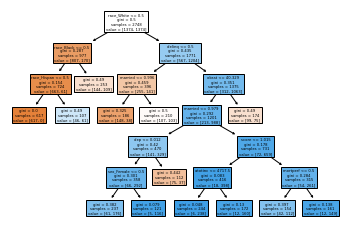

In [107]:
#affichage graphique de l'arbre - depuis sklearn 0.21
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree 
from sklearn.tree import plot_tree
plot_tree(arbreFirst,feature_names = list(data2.columns[1:]),filled=True)

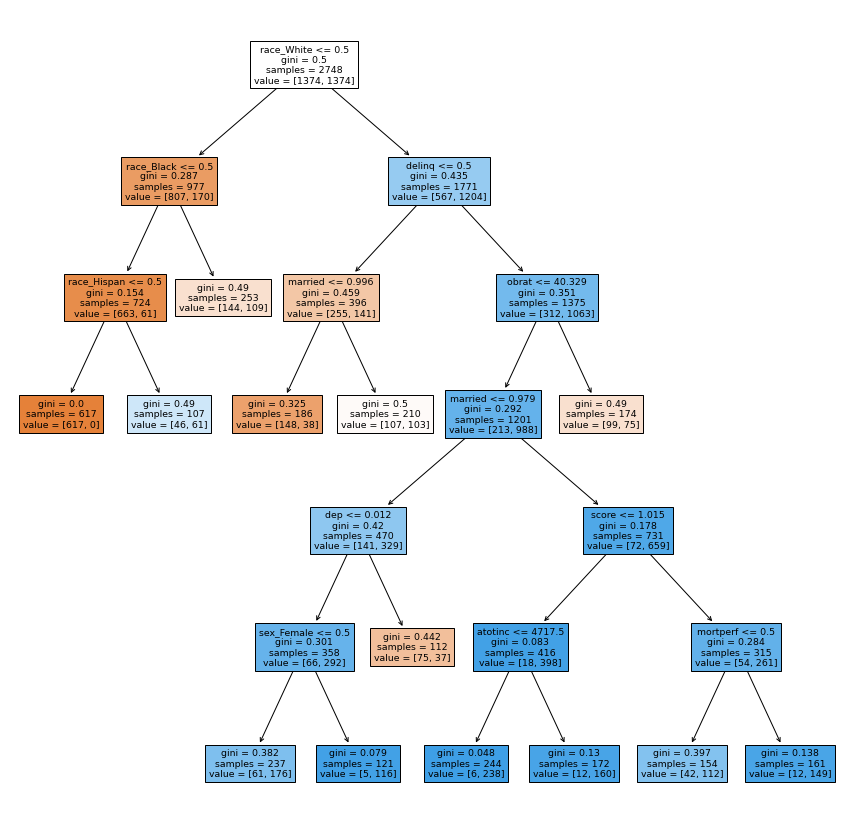

In [108]:
#affichage plus grand pour une meilleure lisibilité
plt.figure(figsize=(15,15))
plot_tree(arbreFirst,feature_names = list(data2.columns[1:]),filled=True) 
plt.show()

## 3. Fôrets aléatoires

In [13]:
clf = RandomForestClassifier(n_estimators=10)
#clf.fit(data_X, data_y)
clf.fit(os_data_X,os_data_y)
y_pred = clf.predict(test_X)
print("Forêt aléatoire (10 arbres) : " + str(clf.score(test_X,test_y)))
# aléatoire, change à chaque fois

Forêt aléatoire (10 arbres) : 0.826530612244898


In [14]:
clf2 = RandomForestClassifier(n_estimators=100)
#clf2.fit(data_X, data_y)
clf2.fit(os_data_X,os_data_y)
y_pred_2 = clf2.predict(test_X)
print("Forêt aléatoire (100 arbres) : " + str(clf2.score(test_X,test_y)))

Forêt aléatoire (100 arbres) : 0.8673469387755102


In [15]:
clf3 = RandomForestClassifier(n_estimators=150)
#clf3.fit(data_X, data_y)
clf3.fit(os_data_X,os_data_y)
y_pred_3 = clf3.predict(test_X)
print("Forêt aléatoire (150 arbres) : " + str(clf3.score(test_X,test_y)))

Forêt aléatoire (150 arbres) : 0.8622448979591837


In [16]:
clf4 = RandomForestClassifier(n_estimators=200)
#clf4.fit(data_X, data_y)
clf4.fit(os_data_X,os_data_y)
y_pred_4 = clf4.predict(test_X)
print("Forêt aléatoire (200 arbres) : " + str(clf4.score(test_X,test_y)))

# nombre optimal de foret ???
# fixer les forets
# plot avec les forets

Forêt aléatoire (200 arbres) : 0.8647959183673469


In [17]:
#PRENDRE TOUTE LES DONNEES APRES VAR DUMMIES ET APRES REEQUILIBRAGE
# PAS FAIRE TRAIN ET TEST
# REEQUILIBRAGE ?? DUMMIE SUR

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, os_data_X,os_data_y, cv=5)
scores.mean()

0.8944911409173704

In [18]:
clf2 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
scores2 = cross_val_score(clf2, os_data_X,os_data_y, cv=5)
scores2.mean()

0.9196052326544131

In [19]:
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, os_data_X,os_data_y, cv=5) #CV à 5 ou 10 ??
scores.mean()

0.8992157641993709

In [20]:
clf2 = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
scores2 = cross_val_score(clf2, os_data_X,os_data_y, cv=5)
scores2.mean()

0.9148706739526412

In [21]:
clf = RandomForestClassifier(n_estimators=50)
clf.fit(os_data_X,os_data_y)
accuracy=clf.score(test_X,test_y)
print("Forêt aléatoire : " + str(accuracy))

Forêt aléatoire : 0.8443877551020408


In [22]:
clf = ExtraTreesClassifier(n_estimators=50)
clf.fit(os_data_X,os_data_y)
accuracy = clf.score(test_X,test_y)
print("Extra Trees : " + str(accuracy))

Extra Trees : 0.8392857142857143
